In [1]:
from sklearn.datasets import make_classification
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score, davies_bouldin_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # 导入3D绘图工具


from sklearn.neighbors import KernelDensity
import random
import math
from scipy.spatial import distance
import re

%load_ext memory_profiler

# Plot Function

In [2]:
# 二维数据
def plot_cluster_1(labels, cluster_centers, X):
    # 按簇标签将数据点分组
    clustered_data = {}
    for i, label in enumerate(labels):
        if label not in clustered_data:
            clustered_data[label] = []
        clustered_data[label].append(X[i])

    # 绘制散点图
    for label, cluster_points in clustered_data.items():
        cluster_points = np.array(cluster_points)
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], s=10, label=f'Cluster {label + 1}')

    # 绘制簇的中心点
    plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker='x', s=80, c='black', label='Cluster Centers')

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.title('Clustering Result')
    plt.show()
    
# 二维数据只使用labels绘制散点图
def plot_cluster_2(labels,X):
    # 按簇标签将数据点分组
    clustered_data = {}
    for i, label in enumerate(labels):
        if label not in clustered_data:
            clustered_data[label] = []
        clustered_data[label].append(X[i])

    # 收集所有簇中心点
    cluster_centers = []
    for label, cluster_points in clustered_data.items():
        if label == -1:
            continue  # 跳过噪声点
        cluster_points = np.array(cluster_points)
        cluster_center = np.mean(cluster_points, axis=0)
        cluster_centers.append(cluster_center)
        
    # 绘制散点图
    for label, cluster_points in clustered_data.items():
        cluster_points = np.array(cluster_points)
        if label == -1:
            # 噪声点用黑色表示
            plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label='Noise', s=2, color='black')
        else:
            cluster_points = np.array(cluster_points)
            plt.scatter(cluster_points[:, 0], cluster_points[:, 1], s=10, label=f'Cluster {label + 1}')
            
    # 绘制所有簇中心点
    cluster_centers = np.array(cluster_centers)
    plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker='x', s=80, c='black', label='Cluster Centers')

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.title('Clustering Result')
    plt.show()

# 三维数据画图
def plot_3d(labels,X):
    # 创建一个3D图形窗口
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
   
    # 绘制每个数据点，根据其聚类标签着色
    for label in set(labels):
        if label == -1:
            color = 'black'
        else:
            color = None  # 默认颜色
        ax.scatter(X[labels == label, 0], X[labels == label, 1], X[labels == label, 2], label=f'Cluster {label}', c=color)


    
    # 设置坐标轴标签
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_zlabel('Feature 3')

    # 添加图例
    ax.legend()

    # 显示图形
    plt.show()

# 黑盒攻击

In [3]:
# donut_score
def max_point_rdensity(points, center, r, R,kde):
    # 计算在(r, R)环内的点的数量这里针对所有点循环了一遍，之后尝试向量矩阵化修改
    points_in_ring = [point for point in points if r <= np.linalg.norm(point - center) <= R]
    points_in_r = [point for point in points if np.linalg.norm(point - center) <=r ]
    
    if(len(points_in_ring)==0):
        return 0,0
    densities = np.exp(kde.score_samples( points_in_ring))
    #print("densities",densities)
    # 索引
    max_density_index = np.argmax(densities)
    #print("points_in_r",points_in_r)
    if(len(points_in_r)==0):
        r_density=0
    else:
       # print("points_in_r",points_in_r)
       # print("kde.score_samples( points_in_r)",kde.score_samples( points_in_r))
        densities = np.exp(kde.score_samples( points_in_r))
        #还没有想好这里要不要除以点的总数
        r_density = np.sum(densities)/len(points_in_r)   

    # partition_density
    points = points_in_ring - center
    if(points.shape[1]==2):#二维数据
        #p_r = np.sqrt(points[:,0]**2 + points[:,1]**2)  # 计算极坐标r
        theta = np.arctan2(points[:,1], points[:,0])  # 计算θ
        #polar = np.column_stack((p_r,theta))
        theta_degrees = np.degrees(theta)
        part_range = np.array([theta_degrees[max_density_index] - 45,
                               theta_degrees[max_density_index] + 45,
                               theta_degrees[max_density_index] - 180 - 45,
                               theta_degrees[max_density_index] - 180 + 45])
        part_range[part_range > 180] -= 2 * np.pi
        part_range[part_range < -180] += 2 * np.pi
        part_num = np.sum((theta_degrees > part_range[0])&(theta_degrees < part_range[1])) + \
            np.sum((theta_degrees > part_range[2])&(theta_degrees < part_range[3]))
        partition_density = part_num / math.pi * (R**2 - r**2)
        
    elif(points.shape[1]==3):#三维数据
        #p_r = np.sqrt(points[:,0]**2 + points[:,1]**2 + points[:,2]**2)  # 计算极坐标r
        theta = np.arctan2(np.sqrt(points[:,0]**2 + points[:,1]**2), points[:,2])  # 计算θ
        fi = np.arctan2(points[:,1], points[:,0])
        #polar = np.column_stack((p_r,theta,fi))
        theta_degrees = np.degrees(theta)
        fi_degrees = np.degrees(fi)
        part_range1 = np.array([theta_degrees[max_density_index] - 45,
                               theta_degrees[max_density_index] + 45,
                               theta_degrees[max_density_index] - 180 - 45,
                               theta_degrees[max_density_index] - 180 + 45])
        part_range1[part_range1 > 180] -= 2 * np.pi
        part_range1[part_range1 < -180] += 2 * np.pi
        part_range2 = np.array([fi_degrees[max_density_index] - 45,
                               fi_degrees[max_density_index] + 45,
                               fi_degrees[max_density_index] - 180 - 45,
                               fi_degrees[max_density_index] - 180 + 45])
        part_range2[part_range2 > 180] -= 2 * np.pi
        part_range2[part_range2 < -180] += 2 * np.pi
        part_num = np.sum((theta_degrees > part_range1[0])&(theta_degrees < part_range1[1])) + \
            np.sum((theta_degrees > part_range1[2])&(theta_degrees < part_range1[3])) + \
            np.sum((fi_degrees > part_range2[0])&(fi_degrees < part_range2[1])) + \
            np.sum((fi_degrees > part_range2[2])&(fi_degrees < part_range2[3]))
        partition_density = part_num / (4/3) * math.pi * (R**3 - r**3)
    
    return partition_density,r_density


def donut_score(points,center,kde):
    points = np.array(points)
    center = np.array(center)
    center_2D = center.reshape(1, -1)
    center_1D = center 
    score=0
    min_density, max_density = float('inf'), float('-inf')
    min_r_density, max_r_density = float('inf'), float('-inf')
    min_r, max_r = float('inf'), float('-inf')
    min_R_r,max_R_r = float('inf'), float('-inf')
    #在这里修改参数！加油！
    C1=2
    C2=1
    C3=2
    C4=3
    max_score=float('-inf')

    
   # print("donut_score func:")
   # print("center:",center)
   # print("points:",points)
    center=center_2D
    M = distance.cdist(center, points, 'euclidean')
    r_min=np.min(M)
    r_max=np.max(M)
    for r in range(math.floor(r_min),math.ceil(r_max)-1):
        for R in range(math.floor(r),math.ceil(r_max)):
            center=center_1D
            density,r_density=max_point_rdensity(points, center, r, R,kde)
            if density>0:
                R_r=R-r
                max_density = max(max_density, density)
                min_density = min(min_density, density)
                max_r_density = max(max_r_density, r_density)
                min_r_density = min(min_r_density, r_density)
                max_r = max(max_r, r)
                min_r = min(min_r, r)
                max_R_r = max(max_R_r, R_r)
                min_R_r = min(min_R_r, R_r)
                if(min_r == max_r):
                    score=0
                else:
                    #缩放数据
                    if (max_r_density - min_r_density)*(max_density - min_density)*(max_r - min_r)*(max_R_r - min_R_r) !=0:
                        r_density_scaled = (r_density - min_r_density) / (max_r_density - min_r_density)
                        density_scaled = (density - min_density) / (max_density - min_density)
                        r_scaled = (r - min_r) / (max_r - min_r)
                        R_r_scaled=(R_r - min_R_r) / (max_R_r - min_R_r)
                        score=C1*r_scaled-C2*R_r_scaled-C3*r_density_scaled+C4*density_scaled
                    else:
                        score=0
                    
                if score > max_score:
                    max_score = score
    return score

In [4]:
# RANDOM WALK

# 对于一个点的random walk
# point 点
# variables 维度
# neighbor_num 邻居的数量
# step_len 搜索步长
def random_walk(center_point,data_points, neighbor_num, start_step_len,kde ):
    points = data_points
    current_point = center_point
    current_point = np.array(current_point)
    
    variables = len(center_point)
    visited_points = [(current_point, 'Initial')]  # 初始点标记为'Initial'
     
    # 计算起始点的d_s
    start_ds=donut_score(data_points,current_point, kde)
    step_len = start_step_len
    
    #print("起始点:",current_point)
    iteration = 1
    epsilon = 0.1
    
    while(step_len > epsilon):
        #print("第",iteration,"次迭代")
        iteration += 1
        
        # 随机选择s个邻居点（u1是游走方向)与起始点的距离相同，但是方向不同
        neighbors=[]
        
        neighbors.append(current_point)
        for s in range(neighbor_num):
            u = [random.uniform(-1,1) for i1 in range(variables)] # 每一个变量的随机向量
                # u1 为标准化之后的随机向量
            u1 = [u[i3]/math.sqrt(sum([u[i2]**2 for i2 in range(variables)])) for i3 in range(variables)]#标准化
            neighbor = [current_point[i4] + step_len*u1[i4] for i4 in range(variables)]
            neighbor = np.array(neighbor)
            neighbors.append(neighbor)

        # 输出邻居
        #print("邻居:",neighbors)
        #计算出每一步的所有邻居的d_s得分
        d_s=[donut_score(points,x1,kde) for x1 in neighbors]
        #for x1 in neighbors:print("x1",x1)
        
        #选最大的d_s对应的neighbor作为起始点
        d_smax=max(d_s)
        current_point=neighbors[d_s.index(d_smax)]
        # 从邻居中选择一个点
        #current_point = random.choice(neighbors)
        visited_points.append((current_point, 'Walked'))  # 游走点标记为'Walked'
        #step = step+1
            
        step_len = step_len/2
        #break

    return visited_points

def multi_random_walk(center_points ,data_points, neighbor_num,start_step_len,kde):
    best_points = []
    for center_point in center_points:
        #print("搜索的点:",point)
        visited_points = random_walk(center_point, data_points, neighbor_num, start_step_len, kde )
        # donut_score(points,point,kde)
        sorted_points = sorted(visited_points, key=lambda x: donut_score(data_points,x[0],kde), reverse=True)
        best_point = sorted_points[:1] #选出最好的那个点
        #all_points.extend(visited_points)
        best_points.extend(best_point)
        
        #all_points.extend(visited_points)
    
    return best_points
    
# def select_by_prob(all_points,p,kde):
#     # 按分数排序并输出
#     sorted_points = sorted(all_points, key=lambda x: donut_score(points,x[0],kde), reverse=True)
#     #print("\n按分数排序后的点：")
#     for point, label in sorted_points:
#         score = donut_score(points,point,kde)
#         #print(f"点: {point}, 分数: {score}, 标记: {label}")   
        
#     #提取出前p% 的数据点
#     num_elements_to_extract = int(len(sorted_points) * p )
#     # 使用切片来提取数据
#     selected_points=sorted_points[:num_elements_to_extract]
    
#     return selected_points

# 二维数据

In [23]:
X, _ = make_classification(n_samples=300, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=4, class_sep=2)

In [24]:
from sklearn.preprocessing import MinMaxScaler

# 创建一个Min-Max归一化器
scaler = MinMaxScaler(feature_range=(-1, 1))
 
X = scaler.fit_transform(X)
X

array([[-7.26402970e-01, -3.83321323e-01],
       [ 2.37722567e-01, -1.84705703e-01],
       [-7.74888038e-01, -6.00687879e-01],
       [ 7.11213220e-01, -3.11064969e-01],
       [-3.20963101e-01,  4.04053986e-01],
       [-7.13955874e-01, -2.16497178e-01],
       [-8.10063556e-01, -8.96122826e-02],
       [-2.43354563e-02,  2.97196370e-01],
       [-5.91863772e-01,  6.61383176e-02],
       [ 1.67223924e-01,  4.21884762e-02],
       [ 8.62005305e-01, -1.88448952e-01],
       [-6.96325104e-01, -2.55316818e-01],
       [ 2.04861710e-01,  2.37252810e-02],
       [ 8.47325118e-02, -1.62093077e-02],
       [-8.82791419e-01, -1.00000000e+00],
       [-6.32708790e-01, -1.59910494e-01],
       [-8.54182102e-01, -6.20714485e-01],
       [-7.14722041e-01, -2.84970392e-01],
       [-6.67387771e-01, -2.54523856e-01],
       [ 1.35025513e-01, -2.66947839e-01],
       [-7.14925376e-01, -4.34150371e-01],
       [-7.14681135e-01, -6.98037046e-02],
       [ 9.63113021e-01, -6.36131517e-01],
       [-6.

In [25]:
%%time
%%memit

if __name__ == "__main__":
    random.seed(760)
    # 生成包含10个随机三维点的列表
    #center_points = [[random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1)] for _ in range(10)]
    #data_points =  [[random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1)] for _ in range(100)]
    
    data_points=X
    center_points=data_points[np.random.choice(data_points.shape[0], 30, replace=False)]
    #center_points=random.sample(data_points, 30)

    # 打印生成的点列表
    print("原始数据点:") 
    data_points = np.array(data_points)
    print(data_points)
    
    # 打印生成的点列表
    print("原始圆心点:") 
    center_points = np.array(center_points)
    print(center_points) 
 
    # 选择核函数和带宽参数
    kernel = 'gaussian'
    bandwidth = 0.1  # 根据需要调整
    # 创建核密度估计模型并拟合数据
    kde = KernelDensity(kernel=kernel, bandwidth=bandwidth)
    kde.fit(data_points) 
    
    
    print("random walk result:")
    neighbor_num = 10  # 每步随机选择的邻居点数量
    start_step_len = 1 #随机行走的起始步长 步长越来越小 
    random_walk_result  = multi_random_walk(center_points, data_points, neighbor_num,start_step_len,kde)
    
    sorted_result = sorted(random_walk_result, key=lambda x: donut_score(data_points, x[0], kde), reverse=True)
    for point, label in sorted_result:
        score = donut_score(data_points,point,kde)
        print(f"点: {point}, 分数: {score}, 标记: {label}")
    print("运行结束")
#     print("selected result:") # 前p% 的数
#     p = 0.3
#     result = select_by_prob(random_walk_result,p,kde)
#     for point, label in result:
#         score = donut_score(points,point,kde)
#         print(f"点: {point}, 分数: {score}, 标记: {label}")


原始数据点:
[[-7.26402970e-01 -3.83321323e-01]
 [ 2.37722567e-01 -1.84705703e-01]
 [-7.74888038e-01 -6.00687879e-01]
 [ 7.11213220e-01 -3.11064969e-01]
 [-3.20963101e-01  4.04053986e-01]
 [-7.13955874e-01 -2.16497178e-01]
 [-8.10063556e-01 -8.96122826e-02]
 [-2.43354563e-02  2.97196370e-01]
 [-5.91863772e-01  6.61383176e-02]
 [ 1.67223924e-01  4.21884762e-02]
 [ 8.62005305e-01 -1.88448952e-01]
 [-6.96325104e-01 -2.55316818e-01]
 [ 2.04861710e-01  2.37252810e-02]
 [ 8.47325118e-02 -1.62093077e-02]
 [-8.82791419e-01 -1.00000000e+00]
 [-6.32708790e-01 -1.59910494e-01]
 [-8.54182102e-01 -6.20714485e-01]
 [-7.14722041e-01 -2.84970392e-01]
 [-6.67387771e-01 -2.54523856e-01]
 [ 1.35025513e-01 -2.66947839e-01]
 [-7.14925376e-01 -4.34150371e-01]
 [-7.14681135e-01 -6.98037046e-02]
 [ 9.63113021e-01 -6.36131517e-01]
 [-6.74487914e-01  1.44120548e-01]
 [-6.22851171e-01 -4.17824433e-01]
 [-8.00717895e-01 -5.32333163e-01]
 [-5.83071573e-01  5.25730355e-01]
 [-6.10172952e-01  1.07249322e-02]
 [ 3.92816494

点: [-0.8521338   0.23165773], 分数: 2.555891238670695, 标记: Walked
点: [ 0.08714102 -1.54523737], 分数: 2.249122807017544, 标记: Walked
点: [ 0.17277203 -1.63938702], 分数: 2.249118683901293, 标记: Walked
点: [ 0.18954471 -1.59908401], 分数: 2.249118683901293, 标记: Walked
点: [ 0.32914322 -1.63412116], 分数: 2.2491103202846974, 标记: Walked
点: [ 0.25455558 -1.71838027], 分数: 2.2490842490842495, 标记: Walked
点: [ 0.58166182 -1.6158657 ], 分数: 2.2490470139771284, 标记: Walked
点: [ 1.94159969 -0.3436212 ], 分数: 2.246913580246914, 标记: Walked
点: [ 0.86521031 -1.54885467], 分数: 2.2465116279069766, 标记: Walked
点: [0.73219844 1.3381473 ], 分数: 2.238649592549476, 标记: Walked
点: [0.40172484 1.604737  ], 分数: 2.2383790226460074, 标记: Walked
点: [1.18709195 1.05536817], 分数: 2.2376111817026683, 标记: Walked
点: [1.03952646 1.20200253], 分数: 2.2376111817026683, 标记: Walked
点: [1.15461784 1.11798526], 分数: 2.2375478927203063, 标记: Walked
点: [1.15697197 1.13078032], 分数: 2.2374193548387096, 标记: Walked
点: [-1.60899083  0.70400166], 分数: 2.2370860

In [26]:
attack_X=X
for point, label in sorted_result:
        score = donut_score(data_points,point,kde)
        attack_X=np.vstack((attack_X, np.array(point)))
        print(f"点: {point}, 分数: {score}, 标记: {label}")


点: [-0.8521338   0.23165773], 分数: 2.555891238670695, 标记: Walked
点: [ 0.08714102 -1.54523737], 分数: 2.249122807017544, 标记: Walked
点: [ 0.17277203 -1.63938702], 分数: 2.249118683901293, 标记: Walked
点: [ 0.18954471 -1.59908401], 分数: 2.249118683901293, 标记: Walked
点: [ 0.32914322 -1.63412116], 分数: 2.2491103202846974, 标记: Walked
点: [ 0.25455558 -1.71838027], 分数: 2.2490842490842495, 标记: Walked
点: [ 0.58166182 -1.6158657 ], 分数: 2.2490470139771284, 标记: Walked
点: [ 1.94159969 -0.3436212 ], 分数: 2.246913580246914, 标记: Walked
点: [ 0.86521031 -1.54885467], 分数: 2.2465116279069766, 标记: Walked
点: [0.73219844 1.3381473 ], 分数: 2.238649592549476, 标记: Walked
点: [0.40172484 1.604737  ], 分数: 2.2383790226460074, 标记: Walked
点: [1.18709195 1.05536817], 分数: 2.2376111817026683, 标记: Walked
点: [1.03952646 1.20200253], 分数: 2.2376111817026683, 标记: Walked
点: [1.15461784 1.11798526], 分数: 2.2375478927203063, 标记: Walked
点: [1.15697197 1.13078032], 分数: 2.2374193548387096, 标记: Walked
点: [-1.60899083  0.70400166], 分数: 2.2370860

In [27]:
# 反归一化
attack_X = scaler.inverse_transform(attack_X)
X = scaler.inverse_transform(X)
attack_X

array([[-2.33026372, -2.60825444],
       [ 1.2711403 , -2.20365737],
       [-2.51137532, -3.05104877],
       [ 3.03982195, -2.46106204],
       [-0.81577964, -1.00430333],
       [-2.28376871, -2.26841933],
       [-2.64277029, -2.0099439 ],
       [ 0.29224618, -1.22198147],
       [-1.82770468, -1.69266656],
       [ 1.00779898, -1.74145444],
       [ 3.60309218, -2.21128269],
       [-2.21791056, -2.34749827],
       [ 1.14839153, -1.77906556],
       [ 0.69965974, -1.86041574],
       [-2.91443867, -3.86448185],
       [-1.98027756, -2.1531474 ],
       [-2.80757115, -3.09184469],
       [-2.28663066, -2.40790515],
       [-2.10981776, -2.34588294],
       [ 0.88752472, -2.37119166],
       [-2.2873902 , -2.71179757],
       [-2.28647786, -1.96959213],
       [ 3.98077094, -3.12325051],
       [-2.13633971, -1.53381006],
       [-1.94345531, -2.67854023],
       [-2.60786042, -2.91180435],
       [-1.79486221, -0.75643812],
       [-1.89609696, -1.80554838],
       [ 1.85047968,

In [10]:
len(attack_X)

330

### K-Means

###### 攻击前 

In [28]:
# 创建K-Means模型
kmeans = KMeans(random_state=42)

# 设置要搜索的K值范围
param_grid = {'n_clusters': range(2, 7)}  # 设置K值的搜索范围

# 定义自定义评分函数，使用轮廓系数
def silhouette_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    score = silhouette_score(X, labels)
    return score

# 使用GridSearchCV执行网格搜索，以寻找最佳K值
grid_search = GridSearchCV(estimator=kmeans, param_grid=param_grid, scoring=silhouette_scorer, cv=5)
grid_search.fit(X)

# 打印最佳K值和对应的轮廓系数
best_k = grid_search.best_params_['n_clusters']

print(f"最佳K值: {best_k}")

最佳K值: 2


In [29]:
# 创建K均值模型，指定簇的数量K
kmeans = KMeans(n_clusters=2, random_state=42)

# 将数据传入模型进行聚类
kmeans.fit(X)

# 获取聚类结果，即每个数据点所属的簇标签
kmeans_labels_before = kmeans.labels_

# 获取簇的中心点坐标
kmeans_centers_before = kmeans.cluster_centers_



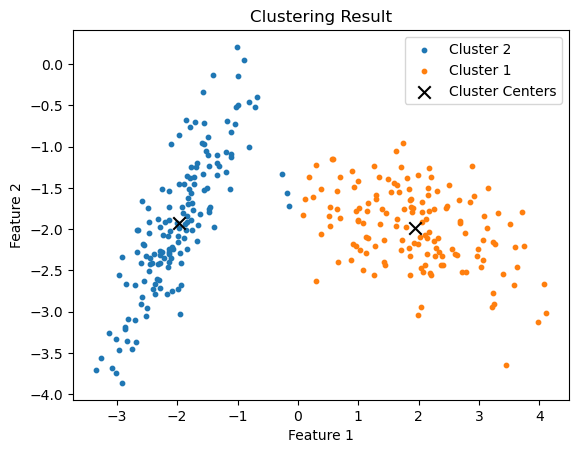

In [30]:
plot_cluster_1(kmeans_labels_before, kmeans_centers_before, X)

##### 攻击后 

In [31]:
# 创建K均值模型，指定簇的数量K
kmeans = KMeans(n_clusters=2, random_state=42)

# 将数据传入模型进行聚类
kmeans.fit(attack_X)

# 获取聚类结果，即每个数据点所属的簇标签
kmeans_labels_after = kmeans.labels_[:300]


# 获取簇的中心点坐标
kmeans_centers_after = kmeans.cluster_centers_

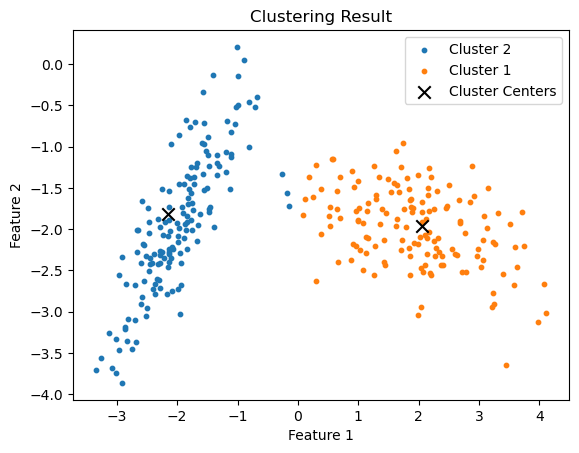

In [32]:
plot_cluster_1(kmeans_labels_after, kmeans_centers_after, X)

In [15]:
print("silhouette score:" ,silhouette_score(X, kmeans_labels_before))
print("davies bouldin score:", davies_bouldin_score(X, kmeans_labels_before))

silhouette score: 0.8367608957085931
davies bouldin score: 0.22845736034553726


In [16]:
print("silhouette score:" ,silhouette_score(X, kmeans_labels_after))
print("davies bouldin score:", davies_bouldin_score(X, kmeans_labels_after))

silhouette score: 0.8367608957085931
davies bouldin score: 0.22845736034553726


In [18]:
np.sum(kmeans_labels_before != kmeans_labels_after)

5

### DBSCAN

###### 攻击前 

In [176]:
from sklearn.model_selection import ParameterGrid
param_grid = {
    'eps': [0.2, 0.3,0.5, 0.7, 1, 3],
    'min_samples': [1, 3, 5]
}

best_score = -1
best_params = {}

for params in ParameterGrid(param_grid):
    dbscan = DBSCAN(eps=params['eps'], min_samples=params['min_samples'])
    labels = dbscan.fit_predict(X[1:100,])
    
    # 忽略-1标签，因为它们表示噪声点
    if len(np.unique(labels)) > 1:
        score = silhouette_score(X[1:100,], labels)
        if score > best_score:
            best_score = score
            best_params = params

print("Best Silhouette Score:", best_score)
print("Best Parameters:", best_params)


Best Silhouette Score: 0.33687246738250864
Best Parameters: {'eps': 0.5, 'min_samples': 5}


In [177]:
# 创建DBSCAN模型
dbscan = DBSCAN(eps=0.2, min_samples=5)

# 进行聚类
dbscan.fit(X)

# 获取聚类结果，每个数据点的簇标签（###### 攻击前 -1 表示噪声点）
dbscan_labels_before = dbscan.labels_

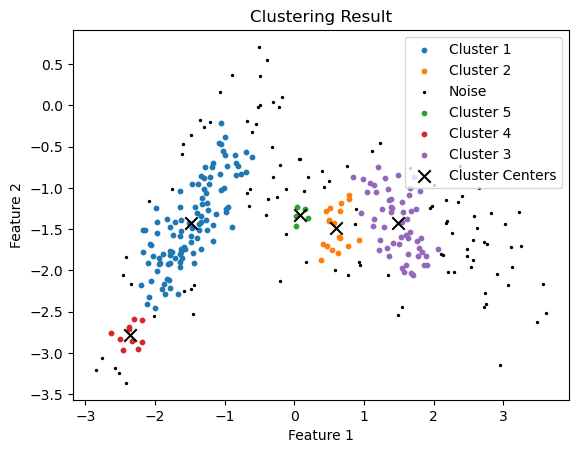

In [178]:
plot_cluster_2(dbscan_labels_before, X)

##### 攻击后 

In [179]:
# 创建DBSCAN模型
dbscan = DBSCAN(eps=0.2, min_samples=5)

# 进行聚类
dbscan.fit(attack_X)

# 获取聚类结果，每个数据点的簇标签（ -1 表示噪声点）
dbscan_labels_after = dbscan.labels_[:300]

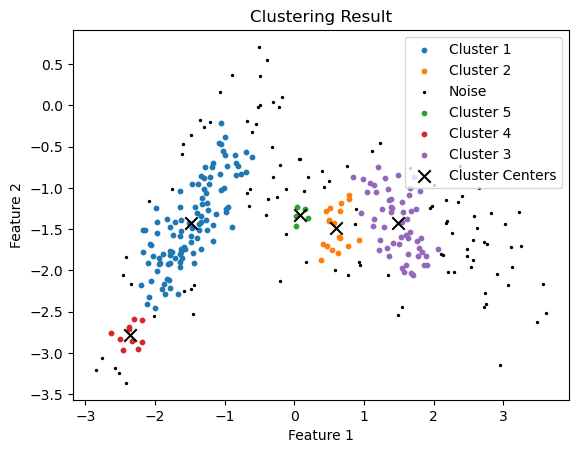

In [180]:
plot_cluster_2(dbscan_labels_after, X)

In [181]:
print("silhouette score:" ,silhouette_score(X, dbscan_labels_before))
print("davies bouldin score:", davies_bouldin_score(X, dbscan_labels_before))

silhouette score: 0.03950638794500411
davies bouldin score: 7.07122660122189


In [182]:
print("silhouette score:" ,silhouette_score(X, dbscan_labels_after))
print("davies bouldin score:", davies_bouldin_score(X, dbscan_labels_after))

silhouette score: 0.03950638794500411
davies bouldin score: 7.07122660122189


### 层次聚类

##### 攻击前 

In [183]:
agg_clustering = AgglomerativeClustering()

# 设置要搜索的K值范围
param_grid = {'n_clusters': range(2, 7)}  # 设置K值的搜索范围

# 定义自定义评分函数，使用轮廓系数
def silhouette_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    score = silhouette_score(X, labels)
    return score

# 使用GridSearchCV执行网格搜索，以寻找最佳K值
grid_search = GridSearchCV(estimator=agg_clustering, param_grid=param_grid, scoring=silhouette_scorer, cv=5)
grid_search.fit(X)

# 打印最佳K值和对应的轮廓系数
best_k = grid_search.best_params_['n_clusters']

print(f"最佳K值: {best_k}")

最佳K值: 2


In [184]:
# 创建层次聚类模型，指定簇的数量
agg_clustering = AgglomerativeClustering(n_clusters=2)

# 进行层次聚类
agg_clustering.fit(X)

# 获取聚类结果，每个数据点的簇标签
agg_labels_before = agg_clustering.labels_

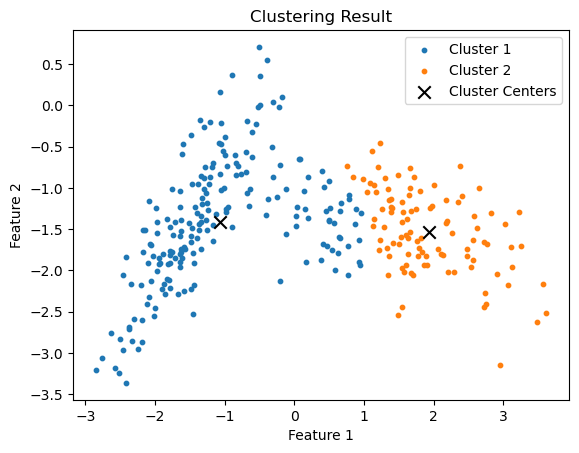

In [185]:
plot_cluster_2(agg_labels_before, X)

##### 攻击后

In [186]:
# 创建层次聚类模型，指定簇的数量
agg_clustering = AgglomerativeClustering(n_clusters=2)

# 进行层次聚类
agg_clustering.fit(attack_X)

# 获取聚类结果，每个数据点的簇标签
agg_labels_after = agg_clustering.labels_[:300]

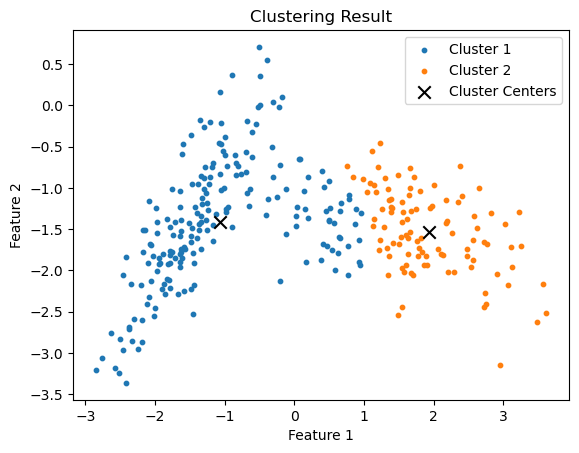

In [187]:
plot_cluster_2(agg_labels_after, X)

In [188]:
print("silhouette score:" ,silhouette_score(X, agg_labels_before))
print("davies bouldin score:", davies_bouldin_score(X, agg_labels_before))

silhouette score: 0.5226418231880336
davies bouldin score: 0.6069078398369301


In [189]:
print("silhouette score:" ,silhouette_score(X, agg_labels_after))
print("davies bouldin score:", davies_bouldin_score(X, agg_labels_after))

silhouette score: 0.5226418231880336
davies bouldin score: 0.6069078398369301


### 高斯混合模型 

##### 攻击前 

In [190]:
gmm = GaussianMixture(random_state=42)

# 设置要搜索的K值范围
param_grid = {'n_components': range(2, 7)}  # 设置K值的搜索范围

# 定义自定义评分函数，使用轮廓系数
def silhouette_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    score = silhouette_score(X, labels)
    return score

# 使用GridSearchCV执行网格搜索，以寻找最佳K值
grid_search = GridSearchCV(estimator=gmm, param_grid=param_grid, scoring=silhouette_scorer, cv=5)
grid_search.fit(X)

# 打印最佳K值和对应的轮廓系数
best_k = grid_search.best_params_['n_components']

print(f"最佳K值: {best_k}")

最佳K值: 2


In [191]:
# 创建GaussianMixture模型
gmm = GaussianMixture(n_components=2, random_state=42)  # 指定高斯分布的数量，也就是簇的数量

# 进行GMM聚类
gmm.fit(X)

# 获取聚类结果，每个数据点的簇标签
gmm_labels_before = gmm.predict(X)

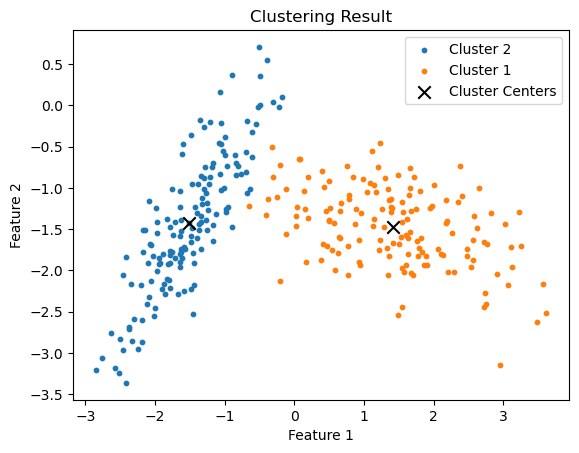

In [192]:
plot_cluster_2(gmm_labels_before, X)

##### 攻击后

In [193]:
# 创建GaussianMixture模型
gmm = GaussianMixture(n_components=2, random_state=42)  # 指定高斯分布的数量，也就是簇的数量

# 进行GMM聚类
gmm.fit(attack_X)

# 获取聚类结果，每个数据点的簇标签
gmm_labels_after = gmm.predict(attack_X)[:300]

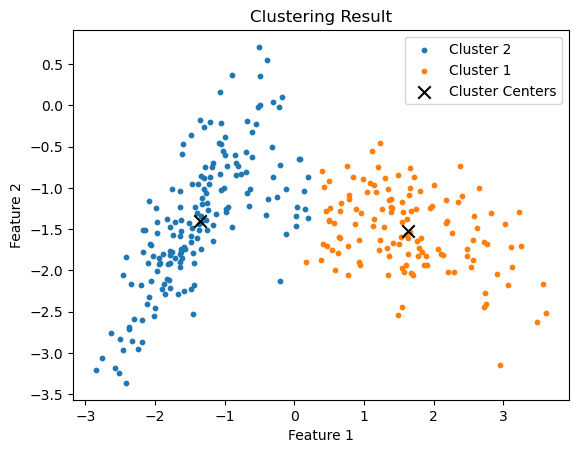

In [194]:
plot_cluster_2(gmm_labels_after, X)

In [195]:
print("silhouette score:" ,silhouette_score(X, gmm_labels_before))
print("davies bouldin score:", davies_bouldin_score(X, gmm_labels_before))

silhouette score: 0.5679450764459546
davies bouldin score: 0.6065340853770377


In [196]:
print("silhouette score:" ,silhouette_score(X, gmm_labels_after))
print("davies bouldin score:", davies_bouldin_score(X, gmm_labels_after))

silhouette score: 0.5858239973938852
davies bouldin score: 0.5774458152932335


# 三维数据

In [5]:
# 读取文件
with open('Skin_NonSkin.txt', 'r') as file:
    lines = file.readlines()

# 初始化X和y的空列表
X = []

# 遍历每一行并分割特征和目标
for line in lines:
    data = line.strip().split('\t')  # 使用制表符分割数据，你可以根据实际情况调整分隔符
    X.append(data[:-1])  # 将除最后一列外的数据添加到X

# 将X和y转换为NumPy数组
X = np.array(X, dtype=float)
X = X[1:300,]

In [6]:
from sklearn.preprocessing import MinMaxScaler

# 创建一个Min-Max归一化器
scaler = MinMaxScaler()
 
X = scaler.fit_transform(X)
X

array([[0.07361963, 0.02702703, 0.02919708],
       [0.06748466, 0.02027027, 0.02189781],
       [0.05521472, 0.00675676, 0.00729927],
       [0.05521472, 0.00675676, 0.00729927],
       [0.04907975, 0.        , 0.        ],
       [0.05521472, 0.00675676, 0.00729927],
       [0.05521472, 0.00675676, 0.00729927],
       [0.09202454, 0.0472973 , 0.05109489],
       [0.09202454, 0.0472973 , 0.05109489],
       [0.09815951, 0.05405405, 0.05839416],
       [0.09815951, 0.05405405, 0.05839416],
       [0.09815951, 0.05405405, 0.05839416],
       [0.10429448, 0.06081081, 0.06569343],
       [0.09815951, 0.03378378, 0.05109489],
       [0.10429448, 0.04054054, 0.05839416],
       [0.10429448, 0.04054054, 0.05839416],
       [0.09815951, 0.03378378, 0.05109489],
       [0.09202454, 0.02702703, 0.04379562],
       [0.09815951, 0.03378378, 0.05109489],
       [0.11656442, 0.05405405, 0.0729927 ],
       [0.13496933, 0.07432432, 0.09489051],
       [0.13496933, 0.07432432, 0.09489051],
       [0.

In [7]:
%%time
%%memit

if __name__ == "__main__":
    random.seed(760)
    # 生成包含10个随机三维点的列表
    #center_points = [[random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1)] for _ in range(10)]
    #data_points =  [[random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1)] for _ in range(100)]
    
    data_points=X
    center_points=data_points[np.random.choice(data_points.shape[0], 30, replace=False)]
    #center_points=random.sample(data_points, 30)

    # 打印生成的点列表
    print("原始数据点:") 
    data_points = np.array(data_points)
    print(data_points)
    
    # 打印生成的点列表
    print("原始圆心点:") 
    center_points = np.array(center_points)
    print(center_points) 
 
    # 选择核函数和带宽参数
    kernel = 'gaussian'
    bandwidth = 0.1  # 根据需要调整
    # 创建核密度估计模型并拟合数据
    kde = KernelDensity(kernel=kernel, bandwidth=bandwidth)
    kde.fit(data_points) 
    
    
    print("random walk result:")
    neighbor_num = 10  # 每步随机选择的邻居点数量
    start_step_len = 1 #随机行走的起始步长 步长越来越小 
    random_walk_result  = multi_random_walk(center_points, data_points, neighbor_num,start_step_len,kde)
    
    sorted_result = sorted(random_walk_result, key=lambda x: donut_score(data_points, x[0], kde), reverse=True)
    for point, label in sorted_result:
        score = donut_score(data_points,point,kde)
        print(f"点: {point}, 分数: {score}, 标记: {label}")
    print("运行结束")
#     print("selected result:") # 前p% 的数
#     p = 0.3
#     result = select_by_prob(random_walk_result,p,kde)
#     for point, label in result:
#         score = donut_score(points,point,kde)
#         print(f"点: {point}, 分数: {score}, 标记: {label}")


原始数据点:
[[0.07361963 0.02702703 0.02919708]
 [0.06748466 0.02027027 0.02189781]
 [0.05521472 0.00675676 0.00729927]
 [0.05521472 0.00675676 0.00729927]
 [0.04907975 0.         0.        ]
 [0.05521472 0.00675676 0.00729927]
 [0.05521472 0.00675676 0.00729927]
 [0.09202454 0.0472973  0.05109489]
 [0.09202454 0.0472973  0.05109489]
 [0.09815951 0.05405405 0.05839416]
 [0.09815951 0.05405405 0.05839416]
 [0.09815951 0.05405405 0.05839416]
 [0.10429448 0.06081081 0.06569343]
 [0.09815951 0.03378378 0.05109489]
 [0.10429448 0.04054054 0.05839416]
 [0.10429448 0.04054054 0.05839416]
 [0.09815951 0.03378378 0.05109489]
 [0.09202454 0.02702703 0.04379562]
 [0.09815951 0.03378378 0.05109489]
 [0.11656442 0.05405405 0.0729927 ]
 [0.13496933 0.07432432 0.09489051]
 [0.13496933 0.07432432 0.09489051]
 [0.14110429 0.08108108 0.10218978]
 [0.14110429 0.08108108 0.10218978]
 [0.13496933 0.07432432 0.09489051]
 [0.11656442 0.05405405 0.0729927 ]
 [0.10429448 0.04054054 0.05839416]
 [0.10429448 0.040540

点: [-0.9141268  -0.20847306  0.37915261], 分数: 2.6085955487336916, 标记: Walked
点: [1.96002708 1.24766645 0.92302523], 分数: 2.607858861267041, 标记: Walked
点: [1.71820964 1.51152882 0.54463182], 分数: 2.607858861267041, 标记: Walked
点: [1.98418032 1.11867062 0.90525665], 分数: 2.607858861267041, 标记: Walked
点: [-0.96395768  0.05979784 -0.18649095], 分数: 2.6072908036454017, 标记: Walked
点: [-0.45074305  0.12693873 -0.85199914], 分数: 2.607052896725441, 标记: Walked
点: [-0.8148462  -0.54952653  0.13222347], 分数: 2.607052896725441, 标记: Walked
点: [-0.82156047  0.03550203  0.61202689], 分数: 2.6054078826764435, 标记: Walked
点: [-0.28122722 -0.5933632   0.80029238], 分数: 2.6007377979568673, 标记: Walked
点: [1.96251485 1.01995231 0.76584994], 分数: 2.590690208667737, 标记: Walked
点: [1.63674604 0.42788896 1.52312585], 分数: 2.573151125401929, 标记: Walked
点: [1.30026576 0.93967649 1.93888347], 分数: 2.55859375, 标记: Walked
点: [1.35793824 0.24138868 1.57383343], 分数: 2.541108986615679, 标记: Walked
点: [0.8687299  1.82957122 1.51753674

In [8]:
attack_X=X
for point, label in sorted_result:
        score = donut_score(data_points,point,kde)
        attack_X=np.vstack((attack_X, np.array(point)))
        print(f"点: {point}, 分数: {score}, 标记: {label}")

点: [-0.9141268  -0.20847306  0.37915261], 分数: 2.6085955487336916, 标记: Walked
点: [1.96002708 1.24766645 0.92302523], 分数: 2.607858861267041, 标记: Walked
点: [1.71820964 1.51152882 0.54463182], 分数: 2.607858861267041, 标记: Walked
点: [1.98418032 1.11867062 0.90525665], 分数: 2.607858861267041, 标记: Walked
点: [-0.96395768  0.05979784 -0.18649095], 分数: 2.6072908036454017, 标记: Walked
点: [-0.45074305  0.12693873 -0.85199914], 分数: 2.607052896725441, 标记: Walked
点: [-0.8148462  -0.54952653  0.13222347], 分数: 2.607052896725441, 标记: Walked
点: [-0.82156047  0.03550203  0.61202689], 分数: 2.6054078826764435, 标记: Walked
点: [-0.28122722 -0.5933632   0.80029238], 分数: 2.6007377979568673, 标记: Walked
点: [1.96251485 1.01995231 0.76584994], 分数: 2.590690208667737, 标记: Walked
点: [1.63674604 0.42788896 1.52312585], 分数: 2.573151125401929, 标记: Walked
点: [1.30026576 0.93967649 1.93888347], 分数: 2.55859375, 标记: Walked
点: [1.35793824 0.24138868 1.57383343], 分数: 2.541108986615679, 标记: Walked
点: [0.8687299  1.82957122 1.51753674

In [9]:
# 反归一化
attack_X = scaler.inverse_transform(attack_X)
X = scaler.inverse_transform(X)
attack_X

array([[ 73.        ,  84.        , 122.        ],
       [ 72.        ,  83.        , 121.        ],
       [ 70.        ,  81.        , 119.        ],
       [ 70.        ,  81.        , 119.        ],
       [ 69.        ,  80.        , 118.        ],
       [ 70.        ,  81.        , 119.        ],
       [ 70.        ,  81.        , 119.        ],
       [ 76.        ,  87.        , 125.        ],
       [ 76.        ,  87.        , 125.        ],
       [ 77.        ,  88.        , 126.        ],
       [ 77.        ,  88.        , 126.        ],
       [ 77.        ,  88.        , 126.        ],
       [ 78.        ,  89.        , 127.        ],
       [ 77.        ,  85.        , 125.        ],
       [ 78.        ,  86.        , 126.        ],
       [ 78.        ,  86.        , 126.        ],
       [ 77.        ,  85.        , 125.        ],
       [ 76.        ,  84.        , 124.        ],
       [ 77.        ,  85.        , 125.        ],
       [ 80.        ,  88.     

### K-Means

###### 攻击前 

In [10]:
# 创建K-Means模型
kmeans = KMeans(random_state=42)

# 设置要搜索的K值范围
param_grid = {'n_clusters': range(2, 7)}  # 设置K值的搜索范围

# 定义自定义评分函数，使用轮廓系数
def silhouette_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    score = silhouette_score(X, labels)
    return score

# 使用GridSearchCV执行网格搜索，以寻找最佳K值
grid_search = GridSearchCV(estimator=kmeans, param_grid=param_grid, scoring=silhouette_scorer, cv=5)
grid_search.fit(X)

# 打印最佳K值和对应的轮廓系数
best_k = grid_search.best_params_['n_clusters']

print(f"最佳K值: {best_k}")

最佳K值: 2


In [11]:
# 创建K均值模型，指定簇的数量K
kmeans = KMeans(n_clusters=2, random_state=42)

# 将数据传入模型进行聚类
kmeans.fit(X)

# 获取聚类结果，即每个数据点所属的簇标签
kmeans_labels_before = kmeans.labels_

# 获取簇的中心点坐标
kmeans_centers_before = kmeans.cluster_centers_

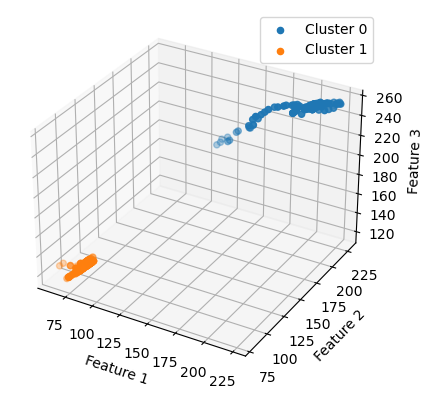

In [12]:
plot_3d(kmeans_labels_before, X)

##### 攻击后 

In [13]:
# 创建K均值模型，指定簇的数量K
kmeans = KMeans(n_clusters=2, random_state=42)

# 将数据传入模型进行聚类
kmeans.fit(attack_X)

# 获取聚类结果，即每个数据点所属的簇标签
kmeans_labels_after = kmeans.labels_[1:300]


# 获取簇的中心点坐标
kmeans_centers_after = kmeans.cluster_centers_

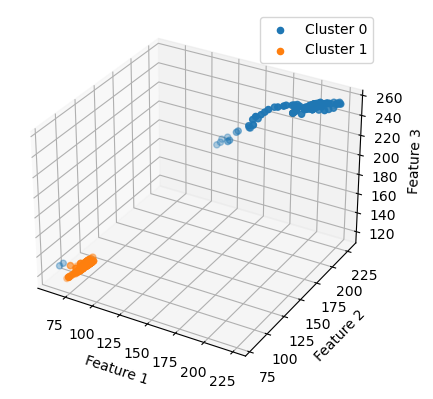

In [14]:
plot_3d(kmeans_labels_after, X)

In [15]:
print("silhouette score:" ,silhouette_score(X, kmeans_labels_before))
print("davies bouldin score:", davies_bouldin_score(X, kmeans_labels_before))

silhouette score: 0.9281255751870097
davies bouldin score: 0.09627277497222406


In [16]:
print("silhouette score:" ,silhouette_score(X, kmeans_labels_after))
print("davies bouldin score:", davies_bouldin_score(X, kmeans_labels_after))

silhouette score: 0.8901195563030633
davies bouldin score: 0.13393389222296126


### DBSCAN

###### 攻击前 

In [17]:
from sklearn.model_selection import ParameterGrid
param_grid = {
    'eps': [1, 3, 5, 6, 7, 8],
    'min_samples': [3, 4, 5]
}

best_score = -1
best_params = {}

for params in ParameterGrid(param_grid):
    dbscan = DBSCAN(eps=params['eps'], min_samples=params['min_samples'])
    labels = dbscan.fit_predict(X)
    
    # 忽略-1标签，因为它们表示噪声点
    if len(np.unique(labels)) > 1:
        score = silhouette_score(X, labels)
        if score > best_score:
            best_score = score
            best_params = params

print("Best Silhouette Score:", best_score)
print("Best Parameters:", best_params)


Best Silhouette Score: 0.8319165778368346
Best Parameters: {'eps': 7, 'min_samples': 4}


In [18]:
# 创建DBSCAN模型
dbscan = DBSCAN(eps=7, min_samples=4)

# 进行聚类
dbscan.fit(X)

# 获取聚类结果，每个数据点的簇标签（###### 攻击前 -1 表示噪声点）
dbscan_labels_before = dbscan.labels_

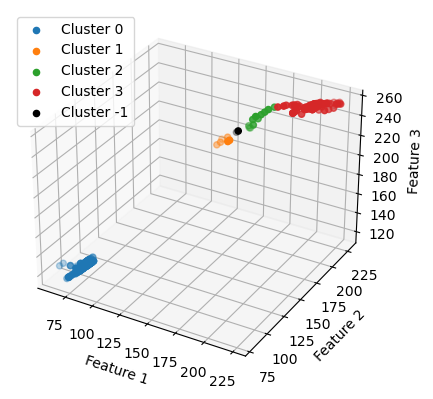

In [19]:
plot_3d(dbscan_labels_before, X)

##### 攻击后 

In [20]:
# 创建DBSCAN模型
dbscan = DBSCAN(eps=7, min_samples=4)

# 进行聚类
dbscan.fit(attack_X)

# 获取聚类结果，每个数据点的簇标签（ -1 表示噪声点）
dbscan_labels_after = dbscan.labels_[1:300]

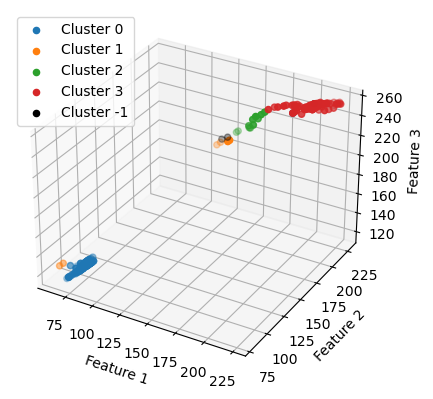

In [21]:
plot_3d(dbscan_labels_after, X)

In [22]:
print("silhouette score:" ,silhouette_score(X, dbscan_labels_before))
print("davies bouldin score:", davies_bouldin_score(X, dbscan_labels_before))

silhouette score: 0.8319165778368346
davies bouldin score: 0.3395712010235465


In [23]:
print("silhouette score:" ,silhouette_score(X, dbscan_labels_after))
print("davies bouldin score:", davies_bouldin_score(X, dbscan_labels_after))

silhouette score: 0.7875593239612778
davies bouldin score: 3.301778276895612


### 层次聚类

##### 攻击前 

In [24]:
agg_clustering = AgglomerativeClustering()

# 设置要搜索的K值范围
param_grid = {'n_clusters': range(2, 7)}  # 设置K值的搜索范围

# 定义自定义评分函数，使用轮廓系数
def silhouette_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    score = silhouette_score(X, labels)
    return score

# 使用GridSearchCV执行网格搜索，以寻找最佳K值
grid_search = GridSearchCV(estimator=agg_clustering, param_grid=param_grid, scoring=silhouette_scorer, cv=5)
grid_search.fit(X)

# 打印最佳K值和对应的轮廓系数
best_k = grid_search.best_params_['n_clusters']

print(f"最佳K值: {best_k}")

最佳K值: 2


In [25]:
# 创建层次聚类模型，指定簇的数量
agg_clustering = AgglomerativeClustering(n_clusters=2)

# 进行层次聚类
agg_clustering.fit(X)

# 获取聚类结果，每个数据点的簇标签
agg_labels_before = agg_clustering.labels_

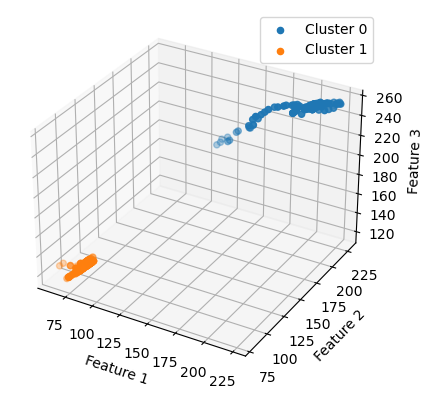

In [26]:
plot_3d(agg_labels_before, X)

##### 攻击后

In [27]:
# 创建层次聚类模型，指定簇的数量
agg_clustering = AgglomerativeClustering(n_clusters=2)

# 进行层次聚类
agg_clustering.fit(attack_X)

# 获取聚类结果，每个数据点的簇标签
agg_labels_after = agg_clustering.labels_[1:300]

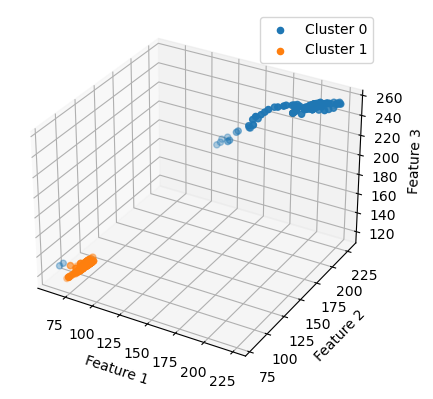

In [28]:
plot_3d(agg_labels_after, X)

In [29]:
print("silhouette score:" ,silhouette_score(X, agg_labels_before))
print("davies bouldin score:", davies_bouldin_score(X, agg_labels_before))

silhouette score: 0.9281255751870097
davies bouldin score: 0.09627277497222406


In [30]:
print("silhouette score:" ,silhouette_score(X, agg_labels_after))
print("davies bouldin score:", davies_bouldin_score(X, agg_labels_after))

silhouette score: 0.8901195563030633
davies bouldin score: 0.13393389222296126


### 高斯混合模型 

##### 攻击前 

In [31]:
gmm = GaussianMixture(random_state=42)

# 设置要搜索的K值范围
param_grid = {'n_components': range(2, 7)}  # 设置K值的搜索范围

# 定义自定义评分函数，使用轮廓系数
def silhouette_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    score = silhouette_score(X, labels)
    return score

# 使用GridSearchCV执行网格搜索，以寻找最佳K值
grid_search = GridSearchCV(estimator=gmm, param_grid=param_grid, scoring=silhouette_scorer, cv=5)
grid_search.fit(X)

# 打印最佳K值和对应的轮廓系数
best_k = grid_search.best_params_['n_components']

print(f"最佳K值: {best_k}")

最佳K值: 2


In [32]:
# 创建GaussianMixture模型
gmm = GaussianMixture(n_components=2, random_state=42)  # 指定高斯分布的数量，也就是簇的数量

# 进行GMM聚类
gmm.fit(X)

# 获取聚类结果，每个数据点的簇标签
gmm_labels_before = gmm.predict(X)

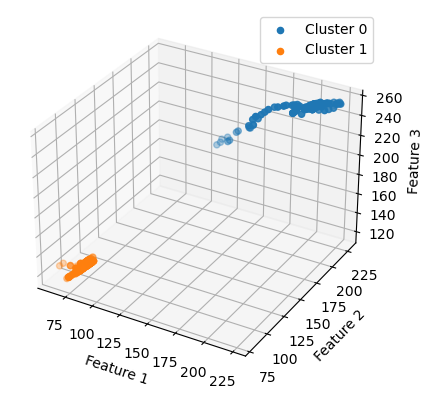

In [33]:
plot_3d(gmm_labels_before, X)

##### 攻击后

In [34]:
# 创建GaussianMixture模型
gmm = GaussianMixture(n_components=2, random_state=42)  # 指定高斯分布的数量，也就是簇的数量

# 进行GMM聚类
gmm.fit(attack_X)

# 获取聚类结果，每个数据点的簇标签
gmm_labels_after = gmm.predict(attack_X)[1:300]

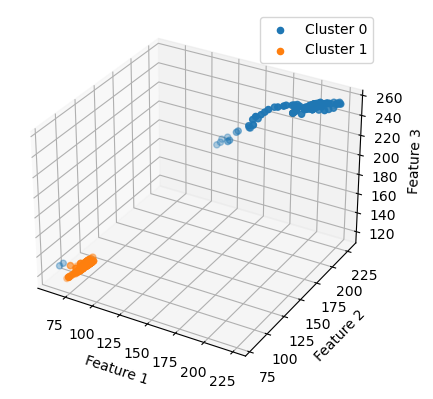

In [35]:
plot_3d(gmm_labels_after, X)

In [36]:
print("silhouette score:" ,silhouette_score(X, gmm_labels_before))
print("davies bouldin score:", davies_bouldin_score(X, gmm_labels_before))

silhouette score: 0.9281255751870097
davies bouldin score: 0.09627277497222406


In [37]:
print("silhouette score:" ,silhouette_score(X, gmm_labels_after))
print("davies bouldin score:", davies_bouldin_score(X, gmm_labels_after))

silhouette score: 0.8901195563030633
davies bouldin score: 0.13393389222296126


In [213]:
np.sum(gmm_labels_before != gmm_labels_after)

6